## HuBMAP - Hacking the Human Vasculature - Inference

## 1. Setup

In [1]:
!pip install /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/addict-2.4.0-py3-none-any.whl
!pip install /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/mmengine-0.7.4-py3-none-any.whl
!pip install /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/mmcv-2.0.0-cp310-cp310-linux_x86_64.whl
!pip install /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/terminaltables-3.1.10-py2.py3-none-any.whl
!pip install /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl --no-index --find-links /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages
!pip install /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/ensemble_boxes-1.0.9-py3-none-any.whl
!pip install /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/mmdet-3.1.0-py3-none-any.whl

Processing /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/addict-2.4.0-py3-none-any.whl
Processing /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/mmengine-0.7.4-py3-none-any.whl
Processing /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/mmcv-2.0.0-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/terminaltables-3.1.10-py2.py3-none-any.whl
Looking in links: /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages
Processing /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/ensemble_boxes-1.0.9-py3-none-any.whl
Processing /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/packages/mmdet-3.1.0-py3-none-any.whl


In [2]:
import sys
sys.path.append('/kaggle/input/hubmap-hacking-the-human-vasculature-dataset/modules')

In [3]:
import os
from pathlib import Path
from glob import glob
import yaml
import base64
import zlib
import warnings

import numpy as np
import pandas as pd
import networkx as nx
import cv2
import tifffile

from numba import jit
import torch
import torch.nn as nn
import mmcv
from mmengine.config import Config
from mmdet.apis import init_detector, inference_detector
from pycocotools import _mask as mask_util
import albumentations as A

import matplotlib.pyplot as plt

In [4]:
competition_dataset = Path('/kaggle/input/hubmap-hacking-the-human-vasculature')
external_dataset = Path('/kaggle/input/hubmap-hacking-the-human-vasculature-dataset')

np.set_printoptions(suppress=True)

In [5]:
image_directory = competition_dataset / 'test'
df = pd.read_csv(competition_dataset / 'sample_submission.csv')
polygons = pd.read_json(competition_dataset / 'polygons.jsonl', lines=True)

verbose = df.shape[0] == 1
visualize = df.shape[0] == 1

print(f'Dataset Shape: {df.shape} - Image Count: {len(os.listdir(image_directory))}')

Dataset Shape: (1, 4) - Image Count: 1


## 2. Annotation Utilities

In [6]:
def decode_rle_mask(rle_mask, shape):

    """
    Decode run-length encoded segmentation mask string into 2d array

    Parameters
    ----------
    rle_mask: str
        Run-length encoded segmentation mask string

    shape: tuple of shape (2)
        Height and width of the mask

    Returns
    -------
    mask: numpy.ndarray of shape (height, width)
        Decoded 2d segmentation mask
    """

    rle_mask = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rle_mask[0:][::2], rle_mask[1:][::2])]
    starts -= 1
    ends = starts + lengths

    mask = np.zeros((shape[0] * shape[1]), dtype=np.uint8)
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    mask = mask.reshape(shape[0], shape[1])
    return mask


def encode_binary_mask(mask):
    
    """
    Encode 2d array into run-length encoded segmentation mask string

    Parameters
    ----------
    mask: numpy.ndarray of shape (height, width)
        2d segmentation mask

    Returns
    -------
    rle_mask: str
        Run-length encoded segmentation mask string
    """

    mask = mask.reshape(mask.shape[0], mask.shape[1], 1).astype(np.uint8)
    mask = np.asfortranarray(mask)
    
    rle_mask = mask_util.encode(mask)[0]['counts']
    rle_mask = zlib.compress(rle_mask, zlib.Z_BEST_COMPRESSION)
    rle_mask = base64.b64encode(rle_mask)
    
    return rle_mask


def binary_to_multi_object_mask(binary_masks):

    """
    Encode multiple 2d binary masks into a single 2d multi-object segmentation mask

    Parameters
    ----------
    binary_masks: numpy.ndarray of shape (n_objects, height, width)
        2d binary masks

    Returns
    -------
    multi_object_mask: numpy.ndarray of shape (height, width)
        2d multi-object mask
    """

    multi_object_mask = np.zeros((binary_masks.shape[1], binary_masks.shape[2]))
    for i, binary_mask in enumerate(binary_masks):
        non_zero_idx = binary_mask == 1
        multi_object_mask[non_zero_idx] = i + 1

    return multi_object_mask


def polygon_to_mask(polygon, shape):

    """
    Create binary segmentation mask from polygon

    Parameters
    ----------
    polygon: list of shape (n_polygons, n_points, 2)
        List of polygons

    shape: tuple of shape (2)
        Height and width of the mask

    Returns
    -------
    mask: numpy.ndarray of shape (height, width)
        2d segmentation mask
    """

    mask = np.zeros(shape)
    # Convert list of points to tuple pairs of X and Y coordinates
    points = np.array(polygon).reshape(-1, 2)
    # Draw mask from the polygon
    cv2.fillPoly(mask, [points], 1, lineType=cv2.LINE_8, shift=0)
    mask = np.array(mask).astype(np.uint8)

    return mask


def mask_to_bounding_box(mask):

    """
    Get bounding box from a binary segmentation mask

    Parameters
    ----------
    mask: numpy.ndarray of shape (height, width)
        2d binary mask

    Returns
    -------
    bounding_box: list of shape (4)
        Bounding box
    """

    non_zero_idx = np.where(mask == 1)
    bounding_box = [
        int(np.min(non_zero_idx[1])),
        int(np.min(non_zero_idx[0])),
        int(np.max(non_zero_idx[1])),
        int(np.max(non_zero_idx[0]))
    ]

    return bounding_box


def decode_hhthv_annotations(annotations, shape):

    """
    Create arrays of mask binary segmentation masks and labels

    Parameters
    ----------
    annotations: list of dictionaries (n_annotations)
        List of dictionaries of polygons and labels

    shape: tuple of shape (2)
        Height and width of the masks

    Returns
    -------
    masks: numpy.ndarray of shape (n_annotations, height, width)
        Array of 2d segmentation masks

    bounding_boxes: numpy.ndarray of shape (n_annotations, 4)
        Array of bounding boxes

    labels: numpy.ndarray of shape (n_annotations)
        Array of labels
    """

    masks = []
    bounding_boxes = []
    labels = []

    for annotation in annotations:

        mask = polygon_to_mask(polygon=annotation['coordinates'], shape=shape)
        bounding_box = mask_to_bounding_box(mask=mask)

        masks.append(mask)
        bounding_boxes.append(bounding_box)
        labels.append(annotation['type'])

    masks = np.array(masks)
    bounding_boxes = np.array(bounding_boxes)
    labels = np.array(labels)

    return masks, bounding_boxes, labels


## 3. Visualization

In [7]:
def visualize_predictions(image, ground_truth, predictions, metadata, path=None):

    """
    Visualize image along with its annotations

    Parameters
    ----------
    image: path-like str or numpy.ndarray of shape (height, width, 3)
        Image path or image array
        
    ground_truth: dict
        Dictionary of ground truth labels
        
    predictions: dict
        Dictionary of model predictions
        
    metadata: dict
        Dictionary of metadata

    path: (path-like str or None)
        Path of the output file or None (if path is None, plot is displayed with selected backend)
    """

    labels = {
        0: 'blood_vessel',
        1: 'glomerulus',
        2: 'unsure'
    }

    if isinstance(image, Path) or isinstance(image, str):
        # Read image from the given path
        image_path = image
        if image_path.endswith('.tif') or image_path.endswith('.tiff'):
            image = tifffile.imread(image_path)
        else:
            image = cv2.imread(image_path, -1)

    elif isinstance(image, np.ndarray):
        title = ''

    else:
        # Raise TypeError if image argument is not an array-like object or a path-like string
        raise TypeError('Image is not an array or path')

    fig, axes = plt.subplots(figsize=(48, 20), ncols=2)

    image_ground_truth = np.copy(image)
    
    if ground_truth is not None:
        for bounding_box, label in zip(ground_truth['boxes'], ground_truth['labels']):
            # Draw bounding box and its label to the image
            image_ground_truth = cv2.rectangle(image_ground_truth, (int(bounding_box[0]), int(bounding_box[1])), (int(bounding_box[2]), int(bounding_box[3])), (36, 255, 12), 2)
            (w, h), _ = cv2.getTextSize(labels[label], cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
            image_ground_truth = cv2.rectangle(image_ground_truth, (int(bounding_box[0]), int(bounding_box[1]) - 20), (int(bounding_box[0]) + w, int(bounding_box[1])), (36, 255, 12), -1)
            image_ground_truth = cv2.putText(image_ground_truth, labels[label], (int(bounding_box[0]), int(bounding_box[1]) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

    axes[0].imshow(image_ground_truth)
    
    if ground_truth is not None:
        mask = binary_to_multi_object_mask(binary_masks=ground_truth['masks'])
        axes[0].imshow(mask, alpha=0.5)

    image_predictions = np.copy(image)
    for bounding_box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
        # Draw bounding box and its label to the image
        image_predictions = cv2.rectangle(image_predictions, (int(bounding_box[0]), int(bounding_box[1])), (int(bounding_box[2]), int(bounding_box[3])), (36, 255, 12), 2)
        text = f'{score:.2f}'
        (w, h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
        image_predictions = cv2.rectangle(image_predictions, (int(bounding_box[0]), int(bounding_box[1]) - 20), (int(bounding_box[0]) + w, int(bounding_box[1])), (36, 255, 12), -1)
        image_predictions = cv2.putText(image_predictions, text, (int(bounding_box[2]), int(bounding_box[3]) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

    axes[1].imshow(image_predictions)

    mask = binary_to_multi_object_mask(binary_masks=predictions['masks'])
    axes[1].imshow(mask, alpha=0.5)

    for i in range(2):
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', labelsize=15, pad=10)
        axes[i].tick_params(axis='y', labelsize=15, pad=10)
    
    if ground_truth is not None:
        axes[0].set_title(f'Image + Ground truth ({ground_truth["labels"].shape[0]} objects)', size=20, pad=15)
    else:
        axes[0].set_title(f'Image', size=25, pad=15)
        
    axes[1].set_title(
        f'''
        Image + Predictions ({predictions['labels'].shape[0]} objects)
        Segmentation AP: {metadata['score']:.4f}
        NMS IoU Threshold: {metadata['nms_iou_threshold']:.2f} - Score Threshold: {metadata['score_threshold']:.2f}
        ''',
        size=25, pad=15
    )

    if path is None:
        plt.show()
    else:
        plt.savefig(path)
        plt.close(fig)


## 4. Semantic Segmentation

In [8]:
class CoaTDAFormer(nn.Module):

    def __init__(self, encoder_name, decoder_args, encoder_weights=None):

        super(CoaTDAFormer, self).__init__()

        self.encoder = getattr(coat, encoder_name)()
        if encoder_weights is not None:
            if encoder_name == 'coat_lite_medium':
                state_dict = torch.load(encoder_weights)['model']
            else:
                state_dict = torch.load(encoder_weights)
            self.encoder.load_state_dict(
                state_dict=state_dict,
                strict=False
            )
        self.decoder = daformer.DAFormerDecoder(**decoder_args)
        self.conv_head = nn.Sequential(
            nn.Conv2d(self.decoder.decoder_dim, 1, kernel_size=1),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
        )

    def forward(self, x):

        x = self.encoder(x)
        last, decoder = self.decoder(x)
        out = self.conv_head(last)

        return out


In [9]:
def load_semantic_segmentation_model(model_directory, model_filenames, device):

    """
    Load semantic segmentation models from given paths

    Parameters
    ----------
    model_directory: pathlib.Path or str
        Path of the model directory

    model_filenames: list of shape (n_models)
        List of model filenames

    device: torch.device
        Location of the model and inputs

    Returns
    -------
    models: dict
        Dictionary of pretrained models

    config: dict
        Dictionary of model configurations
    """

    config = yaml.load(open(model_directory / 'config.yaml', 'r'), Loader=yaml.FullLoader)

    if (config['model']['model_module'] == 'smp') or (config['model']['model_module'] == 'coat_daformer'):
        # Set encoder_weights to None if model module is smp (segmentation_models_pytorch)
        config['model']['model_args']['encoder_weights'] = None
    else:
        raise ValueError('Invalid Model Module')

    models = {}

    for model_filename in model_filenames:
        if config['model']['model_module'] == 'smp':
            model = getattr(smp, config['model']['model_class'])(**config['model']['model_args'])
        elif config['model']['model_module'] == 'coat_daformer':
            model = CoaTDAFormer(**config['model']['model_args'])
        else:
            model = None

        model.load_state_dict(torch.load(model_directory / model_filename))
        model.to(device)
        model.eval()
        models[model_filename] = model

    return models, config


def predict_semantic_segmentation_model(inputs, model, transforms, device, amp=False, tta=False):

    """
    Predict given inputs with given model

    Parameters
    ----------
    inputs: numpy.ndarray of shape (channel, height, width)
        Path of the model directory

    model: torch.nn.Module
        Model

    transforms: albumentations.Compose
        Transforms pipeline

    device: torch.device
        Location of the model and inputs

    amp: bool
        Whether to use auto mixed precision or not

    tta: bool
        Whether to use test time augmentations or not

    Returns
    -------
    outputs: numpy.ndarray of shape (height, width)
        2D array of soft semantic segmentation predictions
    """

    inputs = transforms(image=inputs)['image']
    inputs = torch.unsqueeze(inputs, dim=0)
    inputs = inputs.to(device)

    with torch.no_grad():
        if amp:
            with torch.autocast(device_type=device.type, dtype=torch.float16):
                outputs = model(inputs.half()).float().cpu()
        else:
            outputs = model(inputs).cpu()

    if tta:
        with torch.no_grad():
            vertical_flipped_inputs = inputs.flip(dims=(2,))
            if amp:
                with torch.autocast(device_type=device.type, dtype=torch.float16):
                    vertical_flipped_outputs = model(vertical_flipped_inputs.half()).float().cpu()
            else:
                vertical_flipped_outputs = model(vertical_flipped_inputs).cpu()

            vertical_flipped_outputs = vertical_flipped_outputs.flip(dims=(2,))

            horizontal_flipped_inputs = inputs.flip(dims=(3,))
            if amp:
                with torch.autocast(device_type=device.type, dtype=torch.float16):
                    horizontal_flipped_outputs = model(horizontal_flipped_inputs.half()).float().cpu()
            else:
                horizontal_flipped_outputs = model(horizontal_flipped_inputs).cpu()

            horizontal_flipped_outputs = horizontal_flipped_outputs.flip(dims=(3,))

            vertical_horizontal_flipped_inputs = inputs.flip(dims=(2, 3))
            if amp:
                with torch.autocast(device_type=device.type, dtype=torch.float16):
                    vertical_horizontal_flipped_outputs = model(vertical_horizontal_flipped_inputs.half()).float().cpu()
            else:
                vertical_horizontal_flipped_outputs = model(vertical_horizontal_flipped_inputs).cpu()

            vertical_horizontal_flipped_outputs = vertical_horizontal_flipped_outputs.flip(dims=(2, 3))

        # Concatenate and merge test time augmentations
        outputs = torch.cat([
            outputs.unsqueeze(dim=0),
            vertical_flipped_outputs.unsqueeze(dim=0),
            horizontal_flipped_outputs.unsqueeze(dim=0),
            vertical_horizontal_flipped_outputs.unsqueeze(dim=0)
        ], dim=0).mean(dim=0)

    outputs = torch.sigmoid(outputs)
    outputs = torch.squeeze(torch.squeeze(outputs, dim=0), dim=0).numpy()

    return outputs


def get_semantic_segmentation_transforms(**transform_parameters):

    """
    Get transforms for semantic segmentation dataset

    Parameters
    ----------
    transform_parameters: dict
        Dictionary of transform parameters

    Returns
    -------
    transforms: dict
        Transforms of training and test sets
    """

    test_transforms = A.Compose([
        A.Resize(
            height=transform_parameters['resize_height'],
            width=transform_parameters['resize_width'],
            interpolation=cv2.INTER_NEAREST,
            always_apply=True
        ),
        A.Normalize(
            mean=transform_parameters['normalize_mean'],
            std=transform_parameters['normalize_std'],
            max_pixel_value=255,
            always_apply=True
        ),
        ToTensorV2(always_apply=True)
    ])

    semantic_segmentation_transforms = {'test': test_transforms}
    return semantic_segmentation_transforms


In [10]:
semantic_segmentation_inference = False

if semantic_segmentation_inference:

    coat_daformer_models, coat_daformer_config = load_semantic_segmentation_model(
        model_directory=external_dataset / 'coat_daformer',
        model_filenames=[
            'model_fold1_best.pt',
            'model_fold2_best.pt',
            'model_fold3_best.pt',
            'model_fold4_best.pt',
        ],
        device=torch.device('cuda')
    )
    coat_daformer_transforms = get_semantic_segmentation_transforms(**coat_daformer_config['transforms'])['test']


## 5. Instance Segmentation

In [11]:
def predict_mmdetection(image, model, tta=False):

    """
    Predict given image with given model

    Parameters
    ----------
    image: numpy.ndarray of shape (height, width, channel)
        Image array

    model: torch.nn.Module
        Model

    tta: bool
        Whether to use test time augmentations or not

    Returns
    -------
    predictions: Dict of dicts
        Dictionaries of boxes, masks, labels and scores from single or multiple test time augmentations
    """

    predictions = {}

    outputs = inference_detector(model, imgs=image)
    detections = {
        'boxes': outputs.pred_instances.bboxes.cpu().numpy(),
        'masks': outputs.pred_instances.masks.cpu().numpy(),
        'labels': outputs.pred_instances.labels.cpu().numpy(),
        'scores': outputs.pred_instances.scores.cpu().numpy()
    }
    del outputs
    blood_vessel_mask = detections['labels'] == 0
    for k in detections.keys():
        detections[k] = detections[k][blood_vessel_mask]
    predictions['raw'] = detections

    if tta:
        vertical_flipped_image = np.flip(image, axis=0)
        vertical_flipped_outputs = inference_detector(model, imgs=vertical_flipped_image)
        vertical_flipped_detections = {
            'boxes': vertical_flipped_outputs.pred_instances.bboxes.cpu().numpy(),
            'masks': vertical_flipped_outputs.pred_instances.masks.cpu().numpy(),
            'labels': vertical_flipped_outputs.pred_instances.labels.cpu().numpy(),
            'scores': vertical_flipped_outputs.pred_instances.scores.cpu().numpy()
        }
        del vertical_flipped_outputs
        vertical_flipped_detections['boxes'][:, 1] = image.shape[0] - vertical_flipped_detections['boxes'][:, 1]
        vertical_flipped_detections['boxes'][:, 3] = image.shape[0] - vertical_flipped_detections['boxes'][:, 3]
        vertical_flipped_detections['boxes'][:, 1], vertical_flipped_detections['boxes'][:, 3] = vertical_flipped_detections['boxes'][:, 3], vertical_flipped_detections['boxes'][:, 1].copy()
        vertical_flipped_detections['masks'] = np.flip(vertical_flipped_detections['masks'], axis=1)
        blood_vessel_mask = vertical_flipped_detections['labels'] == 0
        for k in vertical_flipped_detections.keys():
            vertical_flipped_detections[k] = vertical_flipped_detections[k][blood_vessel_mask]
        predictions['vertical_flip'] = vertical_flipped_detections

        horizontal_flipped_image = np.flip(image, axis=1)
        horizontal_flipped_outputs = inference_detector(model, imgs=horizontal_flipped_image)
        horizontal_flipped_detections = {
            'boxes': horizontal_flipped_outputs.pred_instances.bboxes.cpu().numpy(),
            'masks': horizontal_flipped_outputs.pred_instances.masks.cpu().numpy(),
            'labels': horizontal_flipped_outputs.pred_instances.labels.cpu().numpy(),
            'scores': horizontal_flipped_outputs.pred_instances.scores.cpu().numpy()
        }
        del horizontal_flipped_outputs
        horizontal_flipped_detections['boxes'][:, 0] = image.shape[1] - horizontal_flipped_detections['boxes'][:, 0]
        horizontal_flipped_detections['boxes'][:, 2] = image.shape[1] - horizontal_flipped_detections['boxes'][:, 2]
        horizontal_flipped_detections['boxes'][:, 0], horizontal_flipped_detections['boxes'][:, 2] = horizontal_flipped_detections['boxes'][:, 2], horizontal_flipped_detections['boxes'][:, 0].copy()
        horizontal_flipped_detections['masks'] = np.flip(horizontal_flipped_detections['masks'], axis=2)
        blood_vessel_mask = horizontal_flipped_detections['labels'] == 0
        for k in horizontal_flipped_detections.keys():
            horizontal_flipped_detections[k] = horizontal_flipped_detections[k][blood_vessel_mask]
        predictions['horizontal_flip'] = horizontal_flipped_detections

        diagonal_flipped_image = np.flip(image, axis=(0, 1))
        diagonal_flipped_outputs = inference_detector(model, imgs=diagonal_flipped_image)
        diagonal_flipped_detections = {
            'boxes': diagonal_flipped_outputs.pred_instances.bboxes.cpu().numpy(),
            'masks': diagonal_flipped_outputs.pred_instances.masks.cpu().numpy(),
            'labels': diagonal_flipped_outputs.pred_instances.labels.cpu().numpy(),
            'scores': diagonal_flipped_outputs.pred_instances.scores.cpu().numpy()
        }
        del diagonal_flipped_outputs
        diagonal_flipped_detections['boxes'][:, 0] = image.shape[1] - diagonal_flipped_detections['boxes'][:, 0]
        diagonal_flipped_detections['boxes'][:, 1] = image.shape[0] - diagonal_flipped_detections['boxes'][:, 1]
        diagonal_flipped_detections['boxes'][:, 2] = image.shape[1] - diagonal_flipped_detections['boxes'][:, 2]
        diagonal_flipped_detections['boxes'][:, 3] = image.shape[0] - diagonal_flipped_detections['boxes'][:, 3]
        diagonal_flipped_detections['boxes'][:, 0], diagonal_flipped_detections['boxes'][:, 2] = diagonal_flipped_detections['boxes'][:, 2], diagonal_flipped_detections['boxes'][:, 0].copy()
        diagonal_flipped_detections['boxes'][:, 1], diagonal_flipped_detections['boxes'][:, 3] = diagonal_flipped_detections['boxes'][:, 3], diagonal_flipped_detections['boxes'][:, 1].copy()
        diagonal_flipped_detections['masks'] = np.flip(diagonal_flipped_detections['masks'], axis=(1, 2))
        blood_vessel_mask = diagonal_flipped_detections['labels'] == 0
        for k in diagonal_flipped_detections.keys():
            diagonal_flipped_detections[k] = diagonal_flipped_detections[k][blood_vessel_mask]
        predictions['diagonal_flip'] = diagonal_flipped_detections
        
    for k in predictions.keys():
        predictions[k]['mask_lookup'] = {str(np.round(box, 2)): idx for idx, box in enumerate(predictions[k]['boxes'])}

    return predictions


In [12]:
device = 'cuda:0'

mmdetection_mask_rcnn_directory = external_dataset / 'mmdetection_mask_rcnn'
mmdetection_mask_rcnn_config = Config.fromfile(str(mmdetection_mask_rcnn_directory / 'config.py'))
mmdetection_mask_rcnn_models = {
    1: init_detector(mmdetection_mask_rcnn_config, checkpoint=str(mmdetection_mask_rcnn_directory / 'model_fold1_best.pth'), device=device),
    2: init_detector(mmdetection_mask_rcnn_config, checkpoint=str(mmdetection_mask_rcnn_directory / 'model_fold2_best.pth'), device=device),
    3: init_detector(mmdetection_mask_rcnn_config, checkpoint=str(mmdetection_mask_rcnn_directory / 'model_fold3_best.pth'), device=device),
    4: init_detector(mmdetection_mask_rcnn_config, checkpoint=str(mmdetection_mask_rcnn_directory / 'model_fold4_best.pth'), device=device)
}

mmdetection_cascade_mask_rcnn_directory = external_dataset / 'mmdetection_cascade_mask_rcnn'
mmdetection_cascade_mask_rcnn_config = Config.fromfile(str(mmdetection_cascade_mask_rcnn_directory / 'config.py'))
mmdetection_cascade_mask_rcnn_models = {
    1: init_detector(mmdetection_cascade_mask_rcnn_config, checkpoint=str(mmdetection_cascade_mask_rcnn_directory / 'model_fold1_best.pth'), device=device),
    2: init_detector(mmdetection_cascade_mask_rcnn_config, checkpoint=str(mmdetection_cascade_mask_rcnn_directory / 'model_fold2_best.pth'), device=device),
    3: init_detector(mmdetection_cascade_mask_rcnn_config, checkpoint=str(mmdetection_cascade_mask_rcnn_directory / 'model_fold3_best.pth'), device=device),
    4: init_detector(mmdetection_cascade_mask_rcnn_config, checkpoint=str(mmdetection_cascade_mask_rcnn_directory / 'model_fold4_best.pth'), device=device)
}

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Loads checkpoint by local backend from path: /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/mmdetection_mask_rcnn/model_fold1_best.pth
Loads checkpoint by local backend from path: /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/mmdetection_mask_rcnn/model_fold2_best.pth
Loads checkpoint by local backend from path: /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/mmdetection_mask_rcnn/model_fold3_best.pth
Loads checkpoint by local backend from path: /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/mmdetection_mask_rcnn/model_fold4_best.pth
Loads checkpoint by local backend from path: /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/mmdetection_cascade_mask_rcnn/model_fold1_best.pth
Loads checkpoint by local backend from path: /kaggle/input/hubmap-hacking-the-human-vasculature-dataset/mmdetection_cascade_mask_rcnn/model_fold2_best.pth
Loads checkpoint by local backend from path: /kaggle/input/hubmap-hacking-the-human-vasculature-datase

In [13]:
sys.path.append('/kaggle/input/yolov8')
from ultralytics import YOLO

yolo_model = YOLO('/kaggle/input/model-weights/yolov8m-0.395_fulldata.pt')

In [14]:
def TTA_new(im, model, tta_dict, predictions):
    for aug_name, aug in tta_dict.items():
        transform = aug
        ima = transform(image=im)['image']
        pred = model.predict(
            ima,
            imgsz=1024,
            conf = 0.001,
            iou = 0.6
        )[0]
        conf_scores = pred.boxes.conf.detach().cpu().numpy()
        classes = pred.boxes.cls.detach().cpu().numpy()
        pred_masks = pred.masks.data.detach().cpu().numpy()
        pred_boxes = pred.boxes.xyxyn.detach().cpu().numpy()
        del pred
        pred_boxes = transform(image=ima, bboxes=pred_boxes)['bboxes']
        pred_masks = transform(image=ima, masks=pred_masks)['masks']
            
        preds = {
            "boxes" : np.array(pred_boxes),
            "scores" : np.array(conf_scores),
            "masks" : np.array(pred_masks, dtype=np.uint8),
            "labels" : np.array(classes)
        }
        predictions[aug_name] = preds

        del pred_boxes, pred_masks, ima
    
    return predictions

def scaling_boxes(box, scale):
    #simetrik
    box[0] = box[0]*scale
    box[1] = box[1]*scale
    box[2] = box[2]*scale
    box[3] = box[3]*scale
    return box

def post_process_yolo(predictions, img0_shape=(1024,1024), img1_shape=(512,512)):
    scale= 512
    for k in predictions.keys():
        predictions[k]["boxes"] = np.array([scaling_boxes(x, scale) for x in predictions[k]["boxes"]])
        predictions[k]["masks"] = np.array([(cv2.resize(x, dsize=img1_shape,interpolation=cv2.INTER_AREA) > 0).astype(np.uint8) for x in predictions[k]["masks"]])
        
    return predictions

def predict_yolo(image, model, tta=False):
    
    predictions = {}
    
    pred = model.predict(
            image,
            imgsz = 1024,
            conf = 0.001,
            iou = 0.6
    )[0]
    preds = {
        "scores" : pred.boxes.conf.detach().cpu().numpy(),
        "labels" : pred.boxes.cls.detach().cpu().numpy(),
        "masks" : pred.masks.data.detach().cpu().numpy(),
        "boxes" :  pred.boxes.xyxyn.detach().cpu().numpy()
    }
    predictions["raw"] = preds
    
    if tta:
        tta_augs = {
            "horizontal_flip": A.HorizontalFlip(p=1.0),
            "vertical_flip" : A.VerticalFlip(p=1.0),
            "diagonal_flip" : A.Rotate(limit=(180,180), p=1.0)
        }
        
        predictions = TTA_new(image, model, tta_augs, predictions)
        
    
    predictions = post_process_yolo(predictions)
    
    for k in predictions.keys():
        predictions[k]['mask_lookup'] = {str(np.round(box, 2)): idx for idx, box in enumerate(predictions[k]['boxes'])}
        
        
    return predictions


## 6. Post-processing

In [15]:
# coding: utf-8
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'


def prepare_boxes(boxes, scores, labels):
    result_boxes = boxes.copy()

    cond = (result_boxes < 0)
    cond_sum = cond.astype(np.int32).sum()
    if cond_sum > 0:
        print('Warning. Fixed {} boxes coordinates < 0'.format(cond_sum))
        result_boxes[cond] = 0

    cond = (result_boxes > 1)
    cond_sum = cond.astype(np.int32).sum()
    if cond_sum > 0:
        print('Warning. Fixed {} boxes coordinates > 1. Check that your boxes was normalized at [0, 1]'.format(cond_sum))
        result_boxes[cond] = 1

    boxes1 = result_boxes.copy()
    result_boxes[:, 0] = np.min(boxes1[:, [0, 2]], axis=1)
    result_boxes[:, 2] = np.max(boxes1[:, [0, 2]], axis=1)
    result_boxes[:, 1] = np.min(boxes1[:, [1, 3]], axis=1)
    result_boxes[:, 3] = np.max(boxes1[:, [1, 3]], axis=1)

    area = (result_boxes[:, 2] - result_boxes[:, 0]) * (result_boxes[:, 3] - result_boxes[:, 1])
    cond = (area == 0)
    cond_sum = cond.astype(np.int32).sum()
    if cond_sum > 0:
        print('Warning. Removed {} boxes with zero area!'.format(cond_sum))
        result_boxes = result_boxes[area > 0]
        scores = scores[area > 0]
        labels = labels[area > 0]

    return result_boxes, scores, labels


def cpu_soft_nms_float(dets, sc, Nt, sigma, thresh, method):
    """
    Based on: https://github.com/DocF/Soft-NMS/blob/master/soft_nms.py
    It's different from original soft-NMS because we have float coordinates on range [0; 1]

    :param dets:   boxes format [x1, y1, x2, y2]
    :param sc:     scores for boxes
    :param Nt:     required iou 
    :param sigma:  
    :param thresh: 
    :param method: 1 - linear soft-NMS, 2 - gaussian soft-NMS, 3 - standard NMS
    :return: index of boxes to keep
    """

    # indexes concatenate boxes with the last column
    N = dets.shape[0]
    indexes = np.array([np.arange(N)])
    dets = np.concatenate((dets, indexes.T), axis=1)

    # the order of boxes coordinate is [y1, x1, y2, x2]
    y1 = dets[:, 1]
    x1 = dets[:, 0]
    y2 = dets[:, 3]
    x2 = dets[:, 2]
    scores = sc
    areas = (x2 - x1) * (y2 - y1)

    for i in range(N):
        # intermediate parameters for later parameters exchange
        tBD = dets[i, :].copy()
        tscore = scores[i].copy()
        tarea = areas[i].copy()
        pos = i + 1

        #
        if i != N - 1:
            maxscore = np.max(scores[pos:], axis=0)
            maxpos = np.argmax(scores[pos:], axis=0)
        else:
            maxscore = scores[-1]
            maxpos = 0
        if tscore < maxscore:
            dets[i, :] = dets[maxpos + i + 1, :]
            dets[maxpos + i + 1, :] = tBD
            tBD = dets[i, :]

            scores[i] = scores[maxpos + i + 1]
            scores[maxpos + i + 1] = tscore
            tscore = scores[i]

            areas[i] = areas[maxpos + i + 1]
            areas[maxpos + i + 1] = tarea
            tarea = areas[i]

        # IoU calculate
        xx1 = np.maximum(dets[i, 1], dets[pos:, 1])
        yy1 = np.maximum(dets[i, 0], dets[pos:, 0])
        xx2 = np.minimum(dets[i, 3], dets[pos:, 3])
        yy2 = np.minimum(dets[i, 2], dets[pos:, 2])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[pos:] - inter)

        # Three methods: 1.linear 2.gaussian 3.original NMS
        if method == 1:  # linear
            weight = np.ones(ovr.shape)
            weight[ovr > Nt] = weight[ovr > Nt] - ovr[ovr > Nt]
        elif method == 2:  # gaussian
            weight = np.exp(-(ovr * ovr) / sigma)
        else:  # original NMS
            weight = np.ones(ovr.shape)
            weight[ovr > Nt] = 0

        scores[pos:] = weight * scores[pos:]

    # select the boxes and keep the corresponding indexes
    inds = dets[:, 4][scores > thresh]
    keep = inds.astype(int)
    return keep


@jit(nopython=True)
def nms_float_fast(dets, scores, thresh):
    """
    # It's different from original nms because we have float coordinates on range [0; 1]
    :param dets: numpy array of boxes with shape: (N, 5). Order: x1, y1, x2, y2, score. All variables in range [0; 1]
    :param thresh: IoU value for boxes
    :return: index of boxes to keep
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep


def nms_method(boxes, scores, labels, method=3, iou_thr=0.5, sigma=0.5, thresh=0.001, weights=None):
    """
    :param boxes: list of boxes predictions from each model, each box is 4 numbers. 
    It has 3 dimensions (models_number, model_preds, 4)
    Order of boxes: x1, y1, x2, y2. We expect float normalized coordinates [0; 1] 
    :param scores: list of scores for each model 
    :param labels: list of labels for each model
    :param method: 1 - linear soft-NMS, 2 - gaussian soft-NMS, 3 - standard NMS
    :param iou_thr: IoU value for boxes to be a match 
    :param sigma: Sigma value for SoftNMS
    :param thresh: threshold for boxes to keep (important for SoftNMS)
    :param weights: list of weights for each model. Default: None, which means weight == 1 for each model

    :return: boxes: boxes coordinates (Order of boxes: x1, y1, x2, y2). 
    :return: scores: confidence scores
    :return: labels: boxes labels
    """

    # If weights are specified
    if weights is not None:
        if len(boxes) != len(weights):
            print('Incorrect number of weights: {}. Must be: {}. Skip it'.format(len(weights), len(boxes)))
        else:
            weights = np.array(weights)
            for i in range(len(weights)):
                scores[i] = (np.array(scores[i]) * weights[i]) / weights.sum()

    # Do the checks and skip empty predictions
    filtered_boxes = []
    filtered_scores = []
    filtered_labels = []
    for i in range(len(boxes)):
        if len(boxes[i]) != len(scores[i]) or len(boxes[i]) != len(labels[i]):
            print('Check length of boxes and scores and labels: {} {} {} at position: {}. Boxes are skipped!'.format(len(boxes[i]), len(scores[i]), len(labels[i]), i))
            continue
        if len(boxes[i]) == 0:
            # print('Empty boxes!')
            continue
        filtered_boxes.append(boxes[i])
        filtered_scores.append(scores[i])
        filtered_labels.append(labels[i])

    # We concatenate everything
    boxes = np.concatenate(filtered_boxes)
    scores = np.concatenate(filtered_scores)
    labels = np.concatenate(filtered_labels)
    

    # Fix coordinates and removed zero area boxes
    boxes, scores, labels = prepare_boxes(boxes, scores, labels)

    # Run NMS independently for each label
    unique_labels = np.unique(labels)
    final_boxes = []
    final_scores = []
    final_labels = []
    for l in unique_labels:
        condition = (labels == l)
        boxes_by_label = boxes[condition]
        scores_by_label = scores[condition]
        labels_by_label = np.array([l] * len(boxes_by_label))

        if method != 3:
            keep = cpu_soft_nms_float(boxes_by_label.copy(), scores_by_label.copy(), Nt=iou_thr, sigma=sigma, thresh=thresh, method=method)
        else:
            # Use faster function
            keep = nms_float_fast(boxes_by_label, scores_by_label, thresh=iou_thr)

        final_boxes.append(boxes_by_label[keep])
        final_scores.append(scores_by_label[keep])
        final_labels.append(labels_by_label[keep])
    final_boxes = np.concatenate(final_boxes)
    final_scores = np.concatenate(final_scores)
    final_labels = np.concatenate(final_labels)

    return final_boxes, final_scores, final_labels, keep


In [16]:
@jit(nopython=True)
def bb_intersection_over_union(A, B) -> float:
    xA = max(A[0], B[0])
    yA = max(A[1], B[1])
    xB = min(A[2], B[2])
    yB = min(A[3], B[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    if interArea == 0:
        return 0.0

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (A[2] - A[0]) * (A[3] - A[1])
    boxBArea = (B[2] - B[0]) * (B[3] - B[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def prefilter_boxes(boxes, scores, labels, weights, thr):
    # Create dict with boxes stored by its label
    new_boxes = dict()

    for t in range(len(boxes)):

        if len(boxes[t]) != len(scores[t]):
            print('Error. Length of boxes arrays not equal to length of scores array: {} != {}'.format(len(boxes[t]), len(scores[t])))
            sys.exit()

        if len(boxes[t]) != len(labels[t]):
            print('Error. Length of boxes arrays not equal to length of labels array: {} != {}'.format(len(boxes[t]), len(labels[t])))
            sys.exit()

        for j in range(len(boxes[t])):
            score = scores[t][j]
            if score < thr:
                continue
            label = int(labels[t][j])
            box_part = boxes[t][j]
            x1 = max(float(box_part[0]), 0.)
            y1 = max(float(box_part[1]), 0.)
            x2 = max(float(box_part[2]), 0.)
            y2 = max(float(box_part[3]), 0.)

            # Box data checks
            if x2 < x1:
                warnings.warn('X2 < X1 value in box. Swap them.')
                x1, x2 = x2, x1
            if y2 < y1:
                warnings.warn('Y2 < Y1 value in box. Swap them.')
                y1, y2 = y2, y1
            if x1 > 1:
                warnings.warn('X1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                x1 = 1
            if x2 > 1:
                warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                x2 = 1
            if y1 > 1:
                warnings.warn('Y1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                y1 = 1
            if y2 > 1:
                warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                y2 = 1
            if (x2 - x1) * (y2 - y1) == 0.0:
                warnings.warn("Zero area box skipped: {}.".format(box_part))
                continue

            # [label, score, weight, model index, x1, y1, x2, y2]
            b = [int(label), float(score) * weights[t], weights[t], t, x1, y1, x2, y2]
            if label not in new_boxes:
                new_boxes[label] = []
            new_boxes[label].append(b)

    # Sort each list in dict by score and transform it to numpy array
    for k in new_boxes:
        current_boxes = np.array(new_boxes[k])
        new_boxes[k] = current_boxes[current_boxes[:, 1].argsort()[::-1]]

    return new_boxes


def get_weighted_box(boxes, conf_type='avg'):
    """
    Create weighted box for set of boxes
    :param boxes: set of boxes to fuse
    :param conf_type: type of confidence one of 'avg' or 'max'
    :return: weighted box (label, score, weight, x1, y1, x2, y2)
    """

    box = np.zeros(8, dtype=np.float32)
    conf = 0
    conf_list = []
    w = 0
    for b in boxes:
        box[4:] += (b[1] * b[4:])
        conf += b[1]
        conf_list.append(b[1])
        w += b[2]
    box[0] = boxes[0][0]
    if conf_type == 'avg':
        box[1] = conf / len(boxes)
    elif conf_type == 'max':
        box[1] = np.array(conf_list).max()
    elif conf_type in ['box_and_model_avg', 'absent_model_aware_avg']:
        box[1] = conf / len(boxes)
    box[2] = w
    box[3] = -1 # model index field is retained for consistensy but is not used.
    box[4:] /= conf
    return box


def find_matching_box(boxes_list, new_box, match_iou):
    best_iou = match_iou
    best_index = -1
    for i in range(len(boxes_list)):
        box = boxes_list[i]
        if box[0] != new_box[0]:
            continue
        iou = bb_intersection_over_union(box[4:], new_box[4:])
        if iou > best_iou:
            best_index = i
            best_iou = iou

    return best_index, best_iou


def weighted_boxes_fusion_tracking(boxes_list, scores_list, labels_list, weights=None, iou_thr=0.6, skip_box_thr=0.0, conf_type='avg', allows_overflow=False):
    '''
    :param boxes_list: list of boxes predictions from each model, each box is 4 numbers.
    It has 3 dimensions (models_number, model_preds, 4)
    Order of boxes: x1, y1, x2, y2. We expect float normalized coordinates [0; 1]
    :param scores_list: list of scores for each model
    :param labels_list: list of labels for each model
    :param weights: list of weights for each model. Default: None, which means weight == 1 for each model
    :param iou_thr: IoU value for boxes to be a match
    :param skip_box_thr: exclude boxes with score lower than this variable
    :param conf_type: how to calculate confidence in weighted boxes. 'avg': average value, 'max': maximum value, 'box_and_model_avg': box and model wise hybrid weighted average, 'absent_model_aware_avg': weighted average that takes into account the absent model.
    :param allows_overflow: false if we want confidence score not exceed 1.0

    :return: boxes: boxes coordinates (Order of boxes: x1, y1, x2, y2).
    :return: scores: confidence scores
    :return: labels: boxes labels
    :return: wbfo: original boxes coordinates for each fused box
    '''

    if weights is None:
        weights = np.ones(len(boxes_list))
    if len(weights) != len(boxes_list):
        print('Warning: incorrect number of weights {}. Must be: {}. Set weights equal to 1.'.format(len(weights), len(boxes_list)))
        weights = np.ones(len(boxes_list))
    weights = np.array(weights)

    if conf_type not in ['avg', 'max', 'box_and_model_avg', 'absent_model_aware_avg']:
        print('Unknown conf_type: {}. Must be "avg", "max" or "box_and_model_avg", or "absent_model_aware_avg"'.format(conf_type))
        sys.exit()

    filtered_boxes = prefilter_boxes(boxes_list, scores_list, labels_list, weights, skip_box_thr)
    if len(filtered_boxes) == 0:
        return np.zeros((0, 4)), np.zeros((0,)), np.zeros((0,)), np.zeros((0, 4))
    
    overall_boxes = []
    original_boxes = []
    for label in filtered_boxes:
        boxes = filtered_boxes[label]
        new_boxes = []
        weighted_boxes = []
        # Clusterize boxes
        for j in range(0, len(boxes)):
            index, best_iou = find_matching_box(weighted_boxes, boxes[j], iou_thr)
            if index != -1:
                new_boxes[index].append(boxes[j])
                weighted_boxes[index] = get_weighted_box(new_boxes[index], conf_type)
            else:
                new_boxes.append([boxes[j].copy()])
                weighted_boxes.append(boxes[j].copy())
        # Rescale confidence based on number of models and boxes
        original_boxes.append(new_boxes)
        for i in range(len(new_boxes)):
            clustered_boxes = np.array(new_boxes[i])
            if conf_type == 'box_and_model_avg':
                # weighted average for boxes
                weighted_boxes[i][1] = weighted_boxes[i][1] * len(clustered_boxes) / weighted_boxes[i][2]
                # identify unique model index by model index column
                _, idx = np.unique(clustered_boxes[:, 3], return_index=True)
                # rescale by unique model weights
                weighted_boxes[i][1] = weighted_boxes[i][1] *  clustered_boxes[idx, 2].sum() / weights.sum()
            elif conf_type == 'absent_model_aware_avg':
                # get unique model index in the cluster
                models = np.unique(clustered_boxes[:, 3]).astype(int)
                # create a mask to get unused model weights
                mask = np.ones(len(weights), dtype=bool)
                mask[models] = False
                # absent model aware weighted average
                weighted_boxes[i][1] = weighted_boxes[i][1] * len(clustered_boxes) / (weighted_boxes[i][2] + weights[mask].sum())
            elif conf_type == 'max':
                weighted_boxes[i][1] = weighted_boxes[i][1] / weights.max()
            elif not allows_overflow:
                weighted_boxes[i][1] = weighted_boxes[i][1] * min(len(weights), len(clustered_boxes)) / weights.sum()
            else:
                weighted_boxes[i][1] = weighted_boxes[i][1] * len(clustered_boxes) / weights.sum()
        overall_boxes.append(np.array(weighted_boxes))
    overall_boxes = np.concatenate(overall_boxes, axis=0)
    sidx = overall_boxes[:, 1].argsort()
    overall_boxes = overall_boxes[sidx[::-1]]
    boxes = overall_boxes[:, 4:]
    scores = overall_boxes[:, 1]
    labels = overall_boxes[:, 0]
    # sort originals accoring to wbf
    original_boxes = original_boxes[0]
    wbfo = [original_boxes[i] for i in sidx[::-1]]
    return boxes, scores, labels, wbfo


In [17]:
def get_iou_matrix(masks1, masks2):

    """
    Calculate IoU matrix between two sets of masks

    Parameters
    ----------
    masks1: numpy.ndarray of shape (n_objects, height, width)
        Binary masks 1

    masks2: numpy.ndarray of shape (m_objects, height, width)
        Binary masks 2

    Returns
    -------
    iou_matrix: numpy.ndarray of shape (n_objects, m_objects)
        IoU matrix between two sets of masks
    """

    if len(list(masks1)) == 0 or len(list(masks2)) == 0:
        return np.array([[]])
        
    encoded_masks1 = mask_util.encode(np.asfortranarray(np.swapaxes(masks1, 0, -1)))
    encoded_masks2 = mask_util.encode(np.asfortranarray(np.swapaxes(masks2, 0, -1)))
    is_crowd = [0] * len(encoded_masks2)
    iou_matrix = mask_util.iou(encoded_masks1, encoded_masks2, is_crowd)

    return iou_matrix


def blend_masks(masks, mask_shape, scores=None, iou_threshold=0.9, label_threshold=0.5, drop_single_components=True):

    """
    Blend set of multiple masks based on IoU

    Parameters
    ----------
    masks: list of numpy.ndarray of shape (n_objects, height, width)
        List of multiple object masks

    mask_shape: tuple
        Height and width of masks

    iou_threshold: float
        IoU threshold for merging masks (0 <= iou_threshold <= 1)

    label_threshold: float
        Label threshold for converting soft predictions to labels (0 <= iou_threshold <= 1)

    drop_single_components: bool
        Whether to discard predictions without connections or not

    Returns
    -------
    blended_masks: numpy.ndarray of shape (n_objects, height, width)
        Blended binary masks

    blended_scores: numpy.ndarray of shape (n_objects)
        Blended mask scores
    """

    iou_matrices = {}

    # Create pairwise IoU matrices from given list of masks
    for i in range(len(masks)):
        for j in range(i + 1, len(masks)):
            iou_matrix = get_iou_matrix(masks[i], masks[j])
            iou_matrices[f'{i}_{j}'] = iou_matrix

    # Create a graph to store connected masks
    graph = nx.Graph()

    # Add all masks from all lists as nodes
    for list_idx, masks_ in enumerate(masks):
        nodes = [f'{list_idx}_{mask_idx}' for mask_idx in np.arange(len(masks_))]
        graph.add_nodes_from(nodes)

    # Add edges between nodes with IoU >= iou_threshold
    for pair, iou_matrix in iou_matrices.items():
        matching_idx = np.where(iou_matrix >= iou_threshold)
        list1_idx, list2_idx = pair.split('_')
        edges = [(f'{list1_idx}_{mask1_idx}', f'{list2_idx}_{mask2_idx}') for mask1_idx, mask2_idx in zip(*matching_idx)]
        graph.add_edges_from(edges)

    blended_masks = []
    if scores is not None:
        blended_scores = []

    for connections in nx.connected_components(graph):
        if len(connections) == 1:
            if drop_single_components:
                # Skip mask if it isn't connected to any other mask
                continue
            else:
                # Append mask directly if it isn't connected to any other mask
                list_idx, mask_idx = list(connections)[0].split('_')
                list_idx, mask_idx = int(list_idx), int(mask_idx)
                blended_masks.append(masks[list_idx][mask_idx])
                if scores is not None:
                    blended_scores.append(scores[list_idx][mask_idx])
        else:
            # Blend mask with its connections and append
            blended_mask = np.zeros(mask_shape, dtype=np.float32)
            if scores is not None:
                blended_score = []
            for connection in connections:
                list_idx, mask_idx = connection.split('_')
                list_idx, mask_idx = int(list_idx), int(mask_idx)
                # Divide soft predictions with number of connections and accumulate on blended_mask
                blended_mask += (masks[list_idx][mask_idx] / len(connections))
                if scores is not None:
                    # Divide score with number of connections and accumulate on blended_score
                    blended_score.append(scores[list_idx][mask_idx])

            blended_masks.append(blended_mask)
            if scores is not None:
                blended_scores.append((blended_score))

    blended_masks = np.stack(blended_masks)
    # Convert soft predictions to binary labels
    blended_masks = np.uint8(blended_masks >= label_threshold)

    if scores is not None:
        return blended_masks, blended_scores
    else:
        return blended_masks


In [18]:
def get_wsf_mask(wbf_box, wbf_org, shape, predictions, thres=0, scale=False):
    
    mask = np.zeros(shape, dtype=np.uint8)

    for i in range(len(wbf_org)):
        key = str(np.round(wbf_org[i][4:] * shape[0], 2))
        model = int(wbf_org[i][3])
        if key in predictions[model]['mask_lookup']:
            ind = predictions[model]['mask_lookup'][key]
            mask = mask + predictions[model]['masks'][ind]

    # convert thres to integer based on number of boxes
    threshold = max(1, int(thres*len(wbf_org)))
    # remove pixels outside WBF box
    m2 = np.zeros(shape, dtype=np.uint8)
    x1 = max(0, int(shape[0] * wbf_box[0]))
    y1 = max(0, int(shape[1] * wbf_box[1]))
    x2 = min(shape[0], int(shape[0] * wbf_box[2]))
    y2 = min(shape[1], int(shape[1] * wbf_box[3]))

    m2[y1:y2, x1:x2] = 1
    mask = (mask >= threshold) * m2

    return mask.astype(np.uint8)


## 7. Inference


                    Fold: 1 Predictions: 4
                    Predictions Raw: 59 Mean Score: 0.3232
                    Predictions Horizontal Flip: 54 Mean Score: 0.3370
                    Predictions Vertical Flip: 57 Mean Score: 0.3243
                    Predictions Diagonal Flip: 59 Mean Score: 0.3056
                    
Fold: 1 WBF: 109 Mean Score: 0.1692

                    Fold: 2 Predictions: 4
                    Predictions Raw: 45 Mean Score: 0.3223
                    Predictions Horizontal Flip: 45 Mean Score: 0.3238
                    Predictions Vertical Flip: 40 Mean Score: 0.3605
                    Predictions Diagonal Flip: 43 Mean Score: 0.3314
                    
Fold: 2 WBF: 80 Mean Score: 0.1805

                    Fold: 3 Predictions: 4
                    Predictions Raw: 60 Mean Score: 0.3273
                    Predictions Horizontal Flip: 61 Mean Score: 0.3128
                    Predictions Vertical Flip: 64 Mean Score: 0.2890
                    

/opt/conda/lib/python3.10/site-packages/mmdet/models/roi_heads/mask_heads/fcn_mask_head.py:339: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  mask_preds = bboxes.new_tensor(mask_preds)



                    Fold: 1 Predictions: 4
                    Predictions Raw: 66 Mean Score: 0.3038
                    Predictions Horizontal Flip: 57 Mean Score: 0.3392
                    Predictions Vertical Flip: 57 Mean Score: 0.3420
                    Predictions Diagonal Flip: 59 Mean Score: 0.3098
                    
Fold: 1 WBF: 115 Mean Score: 0.1677

                    Fold: 2 Predictions: 4
                    Predictions Raw: 42 Mean Score: 0.3633
                    Predictions Horizontal Flip: 41 Mean Score: 0.3488
                    Predictions Vertical Flip: 44 Mean Score: 0.3469
                    Predictions Diagonal Flip: 36 Mean Score: 0.3404
                    
Fold: 2 WBF: 73 Mean Score: 0.1955

                    Fold: 3 Predictions: 4
                    Predictions Raw: 53 Mean Score: 0.3680
                    Predictions Horizontal Flip: 60 Mean Score: 0.3270
                    Predictions Vertical Flip: 55 Mean Score: 0.3564
                    


0: 1024x1024 135 blood_vessels, 33.0ms
Speed: 5.8ms preprocess, 33.0ms inference, 9.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 150 blood_vessels, 36.2ms
Speed: 5.4ms preprocess, 36.2ms inference, 8.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 121 blood_vessels, 36.2ms
Speed: 6.0ms preprocess, 36.2ms inference, 7.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 145 blood_vessels, 36.2ms
Speed: 6.0ms preprocess, 36.2ms inference, 7.7ms postprocess per image at shape (1, 3, 1024, 1024)



            YOLO Predictions: 4
            Predictions Raw: 135 Mean Score: 0.0596
            Predictions Horizontal Flip: 150 Mean Score: 0.0540
            Predictions Vertical Flip: 121 Mean Score: 0.0637
            Predictions Diagonal Flip: 145 Mean Score: 0.0550
            
Predictions WBF: 531 Mean Score: 0.0268


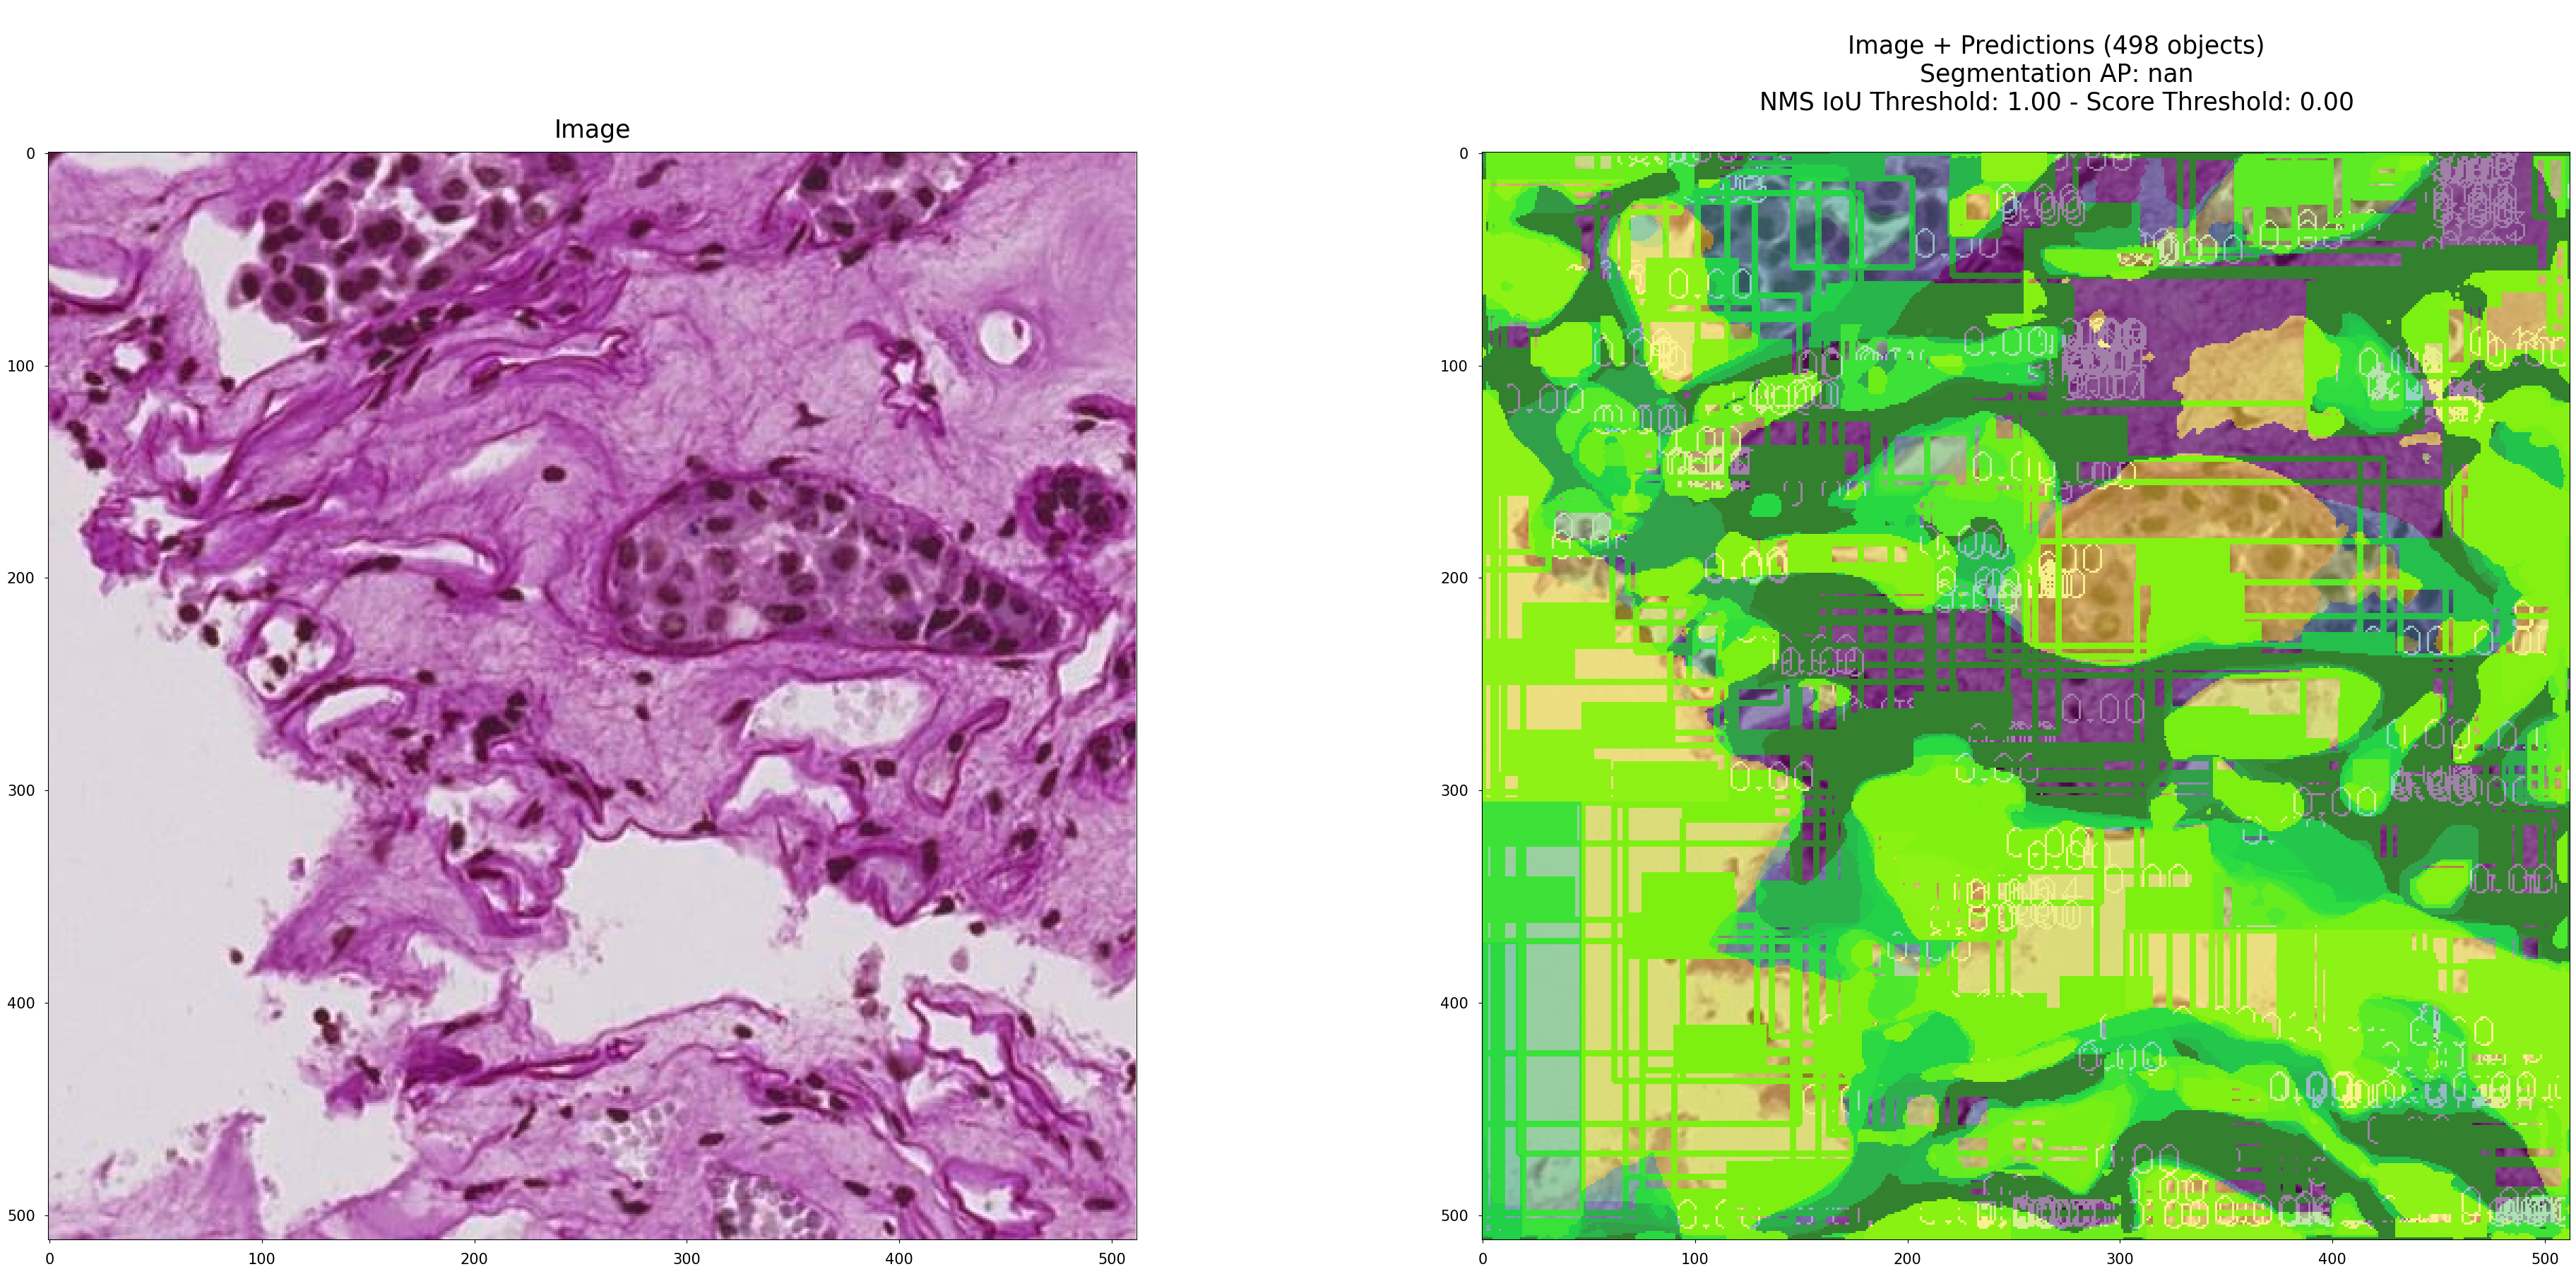

In [19]:
blend = False
area_threshold = 60

image_paths = glob(str(image_directory / '*'))

for image_path in image_paths:

    image_id = image_path.split('/')[-1].split('.')[0]
    image = mmcv.imread(image_path)
    
    predictions = []
    
    for models in [mmdetection_mask_rcnn_models, mmdetection_cascade_mask_rcnn_models]:
    
        for fold in [1, 2, 3, 4]:

            fold_predictions = predict_mmdetection(image, models[fold], tta=True)
            if verbose:
                print(
                    f'''
                    Fold: {fold} Predictions: {len(fold_predictions)}
                    Predictions Raw: {fold_predictions['raw']['scores'].shape[0]} Mean Score: {fold_predictions['raw']['scores'].mean():.4f}
                    Predictions Horizontal Flip: {fold_predictions['horizontal_flip']['scores'].shape[0]} Mean Score: {fold_predictions['horizontal_flip']['scores'].mean():.4f}
                    Predictions Vertical Flip: {fold_predictions['vertical_flip']['scores'].shape[0]} Mean Score: {fold_predictions['vertical_flip']['scores'].mean():.4f}
                    Predictions Diagonal Flip: {fold_predictions['diagonal_flip']['scores'].shape[0]} Mean Score: {fold_predictions['diagonal_flip']['scores'].mean():.4f}
                    '''
                )

            fold_wbf_boxes, fold_wbf_scores, fold_wbf_labels, fold_wbf_originals = weighted_boxes_fusion_tracking(
                boxes_list=[
                    fold_predictions['raw']['boxes'] / 512,
                    fold_predictions['horizontal_flip']['boxes'] / 512,
                    fold_predictions['vertical_flip']['boxes'] / 512,
                    fold_predictions['diagonal_flip']['boxes'] / 512
                ],
                scores_list=[
                    fold_predictions['raw']['scores'],
                    fold_predictions['horizontal_flip']['scores'],
                    fold_predictions['vertical_flip']['scores'],
                    fold_predictions['diagonal_flip']['scores']
                ],
                labels_list=[
                    fold_predictions['raw']['labels'],
                    fold_predictions['horizontal_flip']['labels'],
                    fold_predictions['vertical_flip']['labels'],
                    fold_predictions['diagonal_flip']['labels']
                ],
                weights=None,
                iou_thr=0.8,
                skip_box_thr=0.,
                conf_type='avg',
                allows_overflow=False
            )

            if verbose:
                print(f'Fold: {fold} WBF: {fold_wbf_scores.shape[0]} Mean Score: {fold_wbf_scores.mean():.4f}')

            if fold_wbf_scores.shape[0] > 0:

                fold_wsf_masks = []

                for wbf_box, wbf_score, wbf_original in zip(fold_wbf_boxes, fold_wbf_scores, fold_wbf_originals):
                    if len(wbf_original) > 0:
                        mask = get_wsf_mask(
                            wbf_box,
                            wbf_original,
                            shape=image.shape[:2],
                            predictions=[
                                fold_predictions['raw'],
                                fold_predictions['horizontal_flip'],
                                fold_predictions['vertical_flip'],
                                fold_predictions['diagonal_flip']
                            ],
                            thres=0,
                            scale=True
                        )
                        fold_wsf_masks.append(mask)

                fold_wsf_masks = np.stack(fold_wsf_masks)
            else:
                fold_wsf_masks = np.array([])

            fold_predictions = {
                'boxes': fold_wbf_boxes,
                'masks': fold_wsf_masks,
                'scores': fold_wbf_scores,
                'labels': fold_wbf_labels,
                'mask_lookup': {str(np.round(box * 512, 2)): idx for idx, box in enumerate(fold_wbf_boxes)}
            }
            predictions.append(fold_predictions)
            
    yolo_predictions = predict_yolo(image=image, model=yolo_model, tta=True)
    for k in yolo_predictions.keys():
        yolo_predictions[k]['boxes'] /= 512.
        predictions.append(yolo_predictions[k])
    
    if verbose:
        print(
            f'''
            YOLO Predictions: {len(yolo_predictions)}
            Predictions Raw: {yolo_predictions['raw']['scores'].shape[0]} Mean Score: {yolo_predictions['raw']['scores'].mean():.4f}
            Predictions Horizontal Flip: {yolo_predictions['horizontal_flip']['scores'].shape[0]} Mean Score: {yolo_predictions['horizontal_flip']['scores'].mean():.4f}
            Predictions Vertical Flip: {yolo_predictions['vertical_flip']['scores'].shape[0]} Mean Score: {yolo_predictions['vertical_flip']['scores'].mean():.4f}
            Predictions Diagonal Flip: {yolo_predictions['diagonal_flip']['scores'].shape[0]} Mean Score: {yolo_predictions['diagonal_flip']['scores'].mean():.4f}
            '''
        )
                
    wbf_boxes, wbf_scores, wbf_labels, wbf_originals = weighted_boxes_fusion_tracking(
        boxes_list=[prediction['boxes'] for prediction in predictions],
        scores_list=[prediction['scores'] for prediction in predictions],
        labels_list=[prediction['labels'] for prediction in predictions],
        weights=None,
        iou_thr=0.8,
        skip_box_thr=0.,
        conf_type='avg',
        allows_overflow=False
    )
    
    if verbose:
        print(f'Predictions WBF: {wbf_scores.shape[0]} Mean Score: {wbf_scores.mean():.4f}')
    
    if wbf_scores.shape[0] > 0:

        wsf_masks = []

        for wbf_box, wbf_score, wbf_original in zip(wbf_boxes, wbf_scores, wbf_originals):
            if len(wbf_original) > 0:
                mask = get_wsf_mask(
                    wbf_box,
                    wbf_original,
                    shape=image.shape[:2],
                    predictions=predictions,
                    thres=0
                )
                wsf_masks.append(mask)

        wsf_masks = np.stack(wsf_masks)
    else:
        wsf_masks = np.array([])
            
    if image_id in polygons['id'].values:
        glomerulus_masks, _, _ = decode_hhthv_annotations(polygons.loc[polygons['id'] == image_id, 'annotations'].values[0], shape=(512, 512))
        glomerulus_masks = 1 - np.any(glomerulus_masks == 1, axis=0).astype(np.uint8)
    else:
        glomerulus_masks = np.ones((512, 512))
        
    masks = wsf_masks
    scores = wbf_scores
    
    prediction_string = ''
    
    if len(scores) > 0:
        
        masks = np.stack([mask * glomerulus_masks for mask in masks])
        non_zero_mask_idx = [area >= area_threshold for area in np.sum(masks, axis=(1, 2))]
        masks = masks[non_zero_mask_idx]
        scores = np.array(scores)[non_zero_mask_idx]
        for mask, score in zip(masks, scores):
            
            score *= 1.05
            
            #kernel = np.ones(shape=(3, 3), dtype=np.uint8)
            #mask = cv2.dilate(mask.astype(np.uint8), kernel, 1).astype(bool)
            
            #if score >= 0.95:
                #score = 1.0
            
            encoded_mask = encode_binary_mask(mask).decode()
            prediction_string += f'0 {score} {encoded_mask} '
        
        prediction_string = prediction_string.strip()
        
    df.loc[df['id'] == image_id, 'prediction_string'] = prediction_string
    
    if verbose:
        visualization_outputs = {
            'boxes': [mask_to_bounding_box(mask) for mask in masks],
            'masks': masks.astype(np.uint8),
            'scores': scores,
            'labels': np.zeros(len(masks)),
        }
        visualize_predictions(
            image=image,
            ground_truth=None,
            predictions=visualization_outputs,
            metadata={
                'nms_iou_threshold': 1,
                'score_threshold': 0,
                'score': np.nan
            },
            path=None
        )


In [20]:
df.loc[0, 'prediction_string']

'0 0.9549770683050156 eNoLiwg0TTCItzf0N/Iz8jf0A9GGBv4Ghv6GBkAKSkNJCAaSRv4GYNoQQUKBoT8qjcxCAih6sInBOFBLwYYgOQXoSBALShuBnR0VEWsIAHrkLVM= 0 0.9005766034126282 eNrLj8sySTKItbd3MvA39Dc0wAMM/REkKg9E4sboLEy+oX9MQKgRAGnMHv4= 0 0.8794034510850907 eNoLz8sytk+0N/A38jMEYwhp5G8AwgYgviGCNjTwByIDmBgEg8SgJBKGafIz8jX2NfYz8jMCsUHYLyIo0hgA8oMdBg== 0 0.6980234652757645 eNrLyUs0s06xN/YFQj9DfyMghpAGBiAWjAaSBv4QFogDATAWhIYoRbCM/EAQZiQU+iUGJBsAAGX7G6Q= 0 0.6909310966730118 eNpLDI8xt0m0t/Q09jX0NzQw8Df0R6L9jKCkARAYgkkDCNPfwMjH2M/Yx8TX2M8ICOMyjQDAhxJS 0 0.6835107833147049 eNqLz8wxSTCItzf0MzIw9DXyN/QHsvwNDAyRWEBs4A/EYALMADLBJDILpA5MG0A0GYJkDP2gfJhefwiJpNwfwgKL+YF0pKXlGwIATyciMw== 0 0.6355534315109254 eNqLC8o0s0myN/Ux9jXyA0J/QxAGQgMDEMYACAlDiDJ/sBa/pNxUAwDADBIi 0 0.5827344238758088 eNoLN8w1CLI38TEKdsz3y7QLNfQ38Dc0wAuAStBYIBrCBrP8DIFGGPoa+Rv6G/kZ+hn7puZFmAMA9L0X5g== 0 0.58216552734375 eNrLy88yMsyzN/QHQgMDBAljITAEIFiYPOzA0B+E4wJiTABEDBen 0 0.5374509483575821 eNqLysgytEy1N/Yx8TP0h0MDA2QSSBuAOAYGEEEgByIMA4b+MBZCHJUFxI

In [21]:
df.to_csv('submission.csv', index=False)